In [1]:
!pip install keras keras-preprocessing tensorflow nltk pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00


In [2]:
# Import the necessary Libraries

# from os import listdir
import numpy as np
from numpy import argmax
import pandas as pd
import os
from os import listdir
import random
from matplotlib import pyplot as plt
from collections import Counter
import re
import warnings
import string
from itertools import chain

from pickle import dump
from pickle import load
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, concatenate
from tensorflow.keras.applications import InceptionV3

import keras
from keras import layers
from keras.layers import TextVectorization
from keras.applications import efficientnet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
# import get_cnn_model, TransformerEncoderBlock, TransformerDecoderBlock, ImageCaptioningModel
nltk.download('punkt')
os.environ["KERAS_BACKEND"] = "tensorflow"
keras.utils.set_random_seed(100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## DownLoad Dataset

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("adityajn105/flickr8k")

# print("Path to dataset files:", path)

# download dataset from kaggle
!pip install kaggle
!mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:49<00:00, 24.5MB/s]
100% 1.04G/1.04G [00:49<00:00, 22.6MB/s]


In [4]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

In [5]:
path_to_image = "/content/Images"

# 8,000 images that are each paired with five different captions
caption_data = pd.read_csv('/content/captions.txt')
print(caption_data.shape)
caption_data.head()

(40455, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

## Note that this project used tensorflow and keras libraries for its execution

## Set parameters and Dataset preview

In [6]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)
# Vocabulary size
VOCAB_SIZE = 10000
# Fixed length allowed for any sequence
SEQ_LENGTH = 25
# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512
# Per-layer units in the feed-forward network
FF_DIM = 512
# Other training parameters
BATCH_SIZE = 64
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

## Load and Preprocess Data

In [7]:
def load_captions_data(filename, path_to_image, seq_length):
    caption_data = pd.read_csv(filename)

    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    for _, row in caption_data.iterrows():
        img_name = row['image']
        caption = row['caption']

        img_name = os.path.join(path_to_image, img_name.strip())

        # Tokenize the caption
        tokens = caption.strip().split()

        # Remove captions that are too short or too long
        if len(tokens) < 5 or len(tokens) > seq_length:
            images_to_skip.add(img_name)
            continue

        # Add start and end tokens to each caption
        caption = "<start> " + caption.strip() + " <end>"
        text_data.append(caption)

        # Map captions to the image name
        if img_name in caption_mapping:
            caption_mapping[img_name].append(caption)
        else:
            caption_mapping[img_name] = [caption]

    # Remove skipped images from the caption mapping
    for img_name in images_to_skip:
        if img_name in caption_mapping:
            del caption_mapping[img_name]

    return caption_mapping, text_data

In [8]:
# captions_mapping <key, value>
# text_data is the features value in captions_mapping

captions_mapping, text_data = load_captions_data('/content/captions.txt', path_to_image, SEQ_LENGTH)
print("Dictionary of img filename + captions: ",len(captions_mapping))
print("Just the captions: ",len(text_data))

Dictionary of img filename + captions:  7643
Just the captions:  39994


Instead of using the presplit training, test, and validation.
We set to split the train_size = 0.8, test_size = 0.1, validation size = 0.1


This is to ensure we allocates enought for transformer to increase and capture long-range dependencies and global context without recurrence. To fully utilize this capacity and prevent overfitting

In [9]:
# Split the captioning dataset into train and validation sets.

# caption_data (dict): Dictionary containing the mapped caption data
# train_size (float): Fraction of all the full dataset to use as training data
# shuffle (bool): Whether to shuffle the dataset before splitting

# Set train_size= 0.8, test_size= 0.1
def train_val_split(caption_data, train_size=0.8, shuffle=False):
    test_size=0.1
    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    # train_size = int(len(caption_data) * train_size)
    train_end = int(len(caption_data) * train_size)
    test_end = train_end + int(len(caption_data) * test_size)

    # 4. Split into training, validation, and test sets
    training_data = {img_name: caption_data[img_name] for img_name in all_images[:train_end]}
    test_data = {img_name: caption_data[img_name] for img_name in all_images[train_end:test_end]}
    validation_data = {img_name: caption_data[img_name] for img_name in all_images[test_end:]}

    return training_data, validation_data,test_data

In [10]:
# Preview of the captions_mapping
n = 5
print("Display Top ",n," images with its Captions")
for key, value in dict(list(captions_mapping.items())[:n]).items():
    print(f"Image ID: {key}")
    print(f"Features: {value}")
    print("-" * 50)

Display Top  5  images with its Captions
Image ID: /content/Images/1000268201_693b08cb0e.jpg
Features: ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']
--------------------------------------------------
Image ID: /content/Images/1001773457_577c3a7d70.jpg
Features: ['<start> A black dog and a spotted dog are fighting <end>', '<start> A black dog and a tri-colored dog playing with each other on the road . <end>', '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>', '<start> Two dogs of different breeds looking at each other on the road . <end>', '<start> Two dogs on pavement moving toward each other . <end>']
--------------------------

In [11]:
# Split the dataset into training and validation sets
train_data, valid_data,test_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print("Number of test samples: ", len(test_data))

Number of training samples:  6114
Number of validation samples:  765
Number of test samples:  764


## Preprocess text

It converts the input string to lowercase and removes specific characters specified in the strip_chars variable.

Text Vectorization part involves initializing a TextVectorization layer to convert text data into numerical vectors.

In [12]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


We will generate pairs of images and corresponding captions using a tf.data.Dataset object. The pipeline consists of two steps:

Read the image from the disk
Tokenize all the five captions corresponding to the image

Original image shape: [500 375   3]


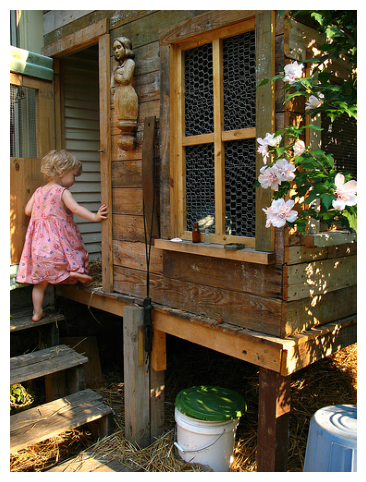

In [13]:
def decode_and_get_original_size(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode image as RGB
    original_shape = tf.shape(img)  # Get the original shape (height, width, channels)
    return img, original_shape

# Sample image path (replace with your actual image path)
img_path = "/content/Images/1000268201_693b08cb0e.jpg"

# Get the original image and its dimensions
img, original_shape = decode_and_get_original_size(img_path)

# Print the original image size (height, width, channels)
print(f"Original image shape: {original_shape.numpy()}")

# Plot the original image
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy())  # Convert tensor to numpy for plotting
plt.axis('off')  # Hide axes
plt.show()


In [14]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

Building the model


The model consists of :
- CNN layer is used for extracting visual features from the input images
- Transformer encoder applies self-attention that converts different parts of visual input and encodes it into a meaningful representation
- Transformer decoder generates captions based on the encoder output
- Sequential layer is used for assembling the components of the model.

In [15]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

## Define Model Architectures

Transfer learning is implicitly utilized when loading the pre-trained InceptionV3 model for extracting image features. By setting weights="imagenet", the model is initialized with weights pre-trained on the ImageNet dataset, which contains a large number of labeled images. This initialization allows the model to capture general visual features that are useful for various image-related tasks.

In [16]:
def get_cnn_model():
    base_model = InceptionV3(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )

    base_model.trainable = False # Freeze the feature extractor
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [17]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            out_1,
            out_1,
            out_1,
            attention_mask=None,
            training=training
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        return out_2

In [18]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [19]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)
        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)

In [20]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.encoder_input_shape = cnn_model.output_shape[1:]
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def call(self, inputs, training=None, mask=None):
        # Pass the input through the CNN model
        img_embed = self.cnn_model(inputs)
        # Pass the embedded image through the encoder and decoder
        # (omitting the loop for multiple captions for simplicity)
        output = self.decoder(self.encoder(img_embed), training=training, mask=mask)
        return output


    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [21]:
# Record the results
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

class MetricTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss_values.append(logs.get('loss'))
        train_accuracy_values.append(logs.get('acc'))  # Use 'accuracy' instead of 'acc'
        val_loss_values.append(logs.get('val_loss'))
        val_accuracy_values.append(logs.get('val_acc'))  # Use 'val_accuracy' instead of 'val_acc'


Model training

In [22]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

cnn_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [24]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# This is going to take a while so just skip this and load the model
# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

## Can skip this part if you already have the model saved

In [25]:
# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, MetricTracker()],
)

# Save model weights with the correct filename format
os.makedirs("models/", exist_ok=True)
caption_model.save_weights('models/transformer_model_weights_inception.weights.h5')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - acc: 0.1681 - loss: 31.9386 - val_acc: 0.3079 - val_loss: 20.2486
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 910ms/step - acc: 0.3111 - loss: 19.8748 - val_acc: 0.3304 - val_loss: 18.5470
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 88s 913ms/step - acc: 0.3363 - loss: 18.2384 - val_acc: 0.3475 - val_loss: 17.7729
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 910ms/step - acc: 0.3484 - loss: 17.3346 - val_acc: 0.3532 - val_loss: 17.2672
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 910ms/step - acc: 0.3581 - loss: 16.6838 - val_acc: 0.3599 - val_loss: 16.9070
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 910ms/step - acc: 0.3668 - loss: 16.1395 - val_acc: 0.3633 - val_loss: 16.6884
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 910ms/step - acc: 0.3744 - loss: 15.6995 - val_acc: 0.3677 - val_loss: 16.5087
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 909ms/step - acc: 0.3810 - loss: 15.3252 - val_acc: 0.3691 - val_loss: 16.4164
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 88s 912

In [26]:
print(train_accuracy_values)

[0.2339233160018921, 0.31566280126571655, 0.3374496400356293, 0.3495393693447113, 0.35991397500038147, 0.3683297634124756, 0.3752000331878662, 0.382295697927475, 0.3885723650455475, 0.3943873643875122]


In [30]:
print(val_accuracy_values)

[0.3079, 0.3304, 0.3475, 0.3532, 0.3599, 0.3633, 0.3677, 0.3691, 0.3712, 0.3726]


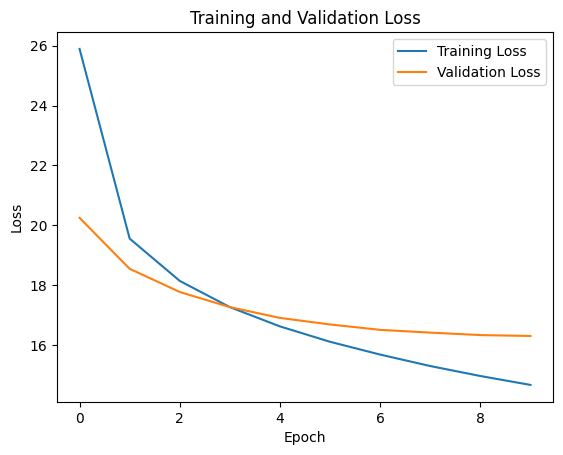

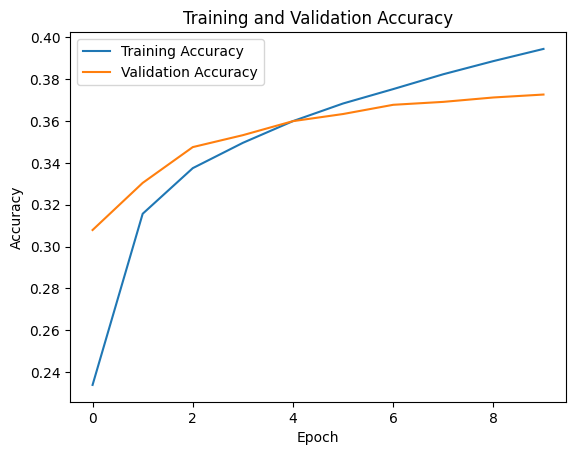

In [31]:
# Plot training and validation loss
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load Model from file directory

In [33]:
# Load model weight
caption_model.load_weights('models/transformer_model_weights_inception.weights.h5')
# caption_model.summary()
print("model loaded")

model loaded


## Evaluating the trained models on random images in testing dataset

In [34]:
# Testing the model

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

In [35]:
def generate_caption(sample_img):
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    encoded_img = caption_model.encoder(img, training=False)

    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])

        # Check if the sampled_token_index exists in index_lookup
        sampled_token = index_lookup.get(sampled_token_index, "<unknown>")

        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    return decoded_caption



In [36]:
def evaluate_random_images(model, test_data, vectorization, num_images):
    bleu_scores = []

    # Convert dictionary view object to a list of tuples
    test_data_list = list(test_data.items())

    # Randomly select num_images images
    random_images = random.sample(test_data_list, num_images)

    for img_path, true_captions in random_images:
        # Generate predicted caption
        predicted_caption = generate_caption(img_path)

        # Calculate BLEU score
        chencherry = SmoothingFunction()
        bleu_score = sentence_bleu(true_captions, predicted_caption, smoothing_function=chencherry.method1)
        bleu_scores.append(bleu_score)

        # Load and display the image
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Print true caption, predicted caption, and BLEU score
        true_captions_ = [caption.replace("<start> ", "").replace(" <end>", "").strip() for caption in true_captions]
        print("True Caption:", true_captions_,"\n")
        predicted_caption_ = predicted_caption.replace("<unknown> ", "").strip()
        print("Predicted Caption:", predicted_caption_,"\n")
        print("BLEU Score:", bleu_score)
        print("=" * 50)

    # Compute average BLEU score
    if bleu_scores:
        average_bleu = sum(bleu_scores) / len(bleu_scores)
    else:
        average_bleu = 0
    return average_bleu


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


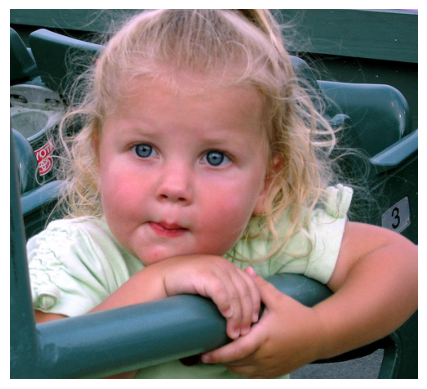

True Caption: ['A blonde toddler in a light green shirt sitting in a green chair surrounded by other green chairs .', 'A cute toddler girl waits in her stroller .', 'A little blonde girl is sitting on a green chair .', 'A little girl is turned around in her seat at an event .', 'A young girl with blond hair holding onto a rail'] 

Predicted Caption: a man in a white shirt and black shirt is standing on a wooden bench 

BLEU Score: 0.517300719409421


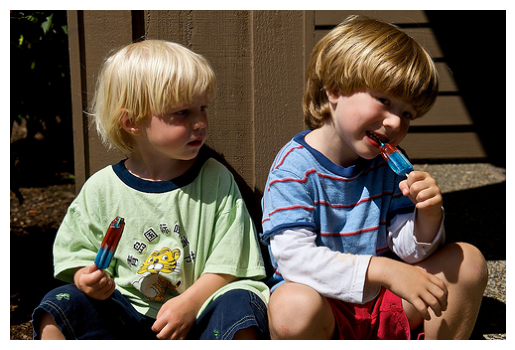

True Caption: ['Two boys are sitting in front of a structure eating Popsicles .', 'Two boys eating popscicles outside .', 'Two boys sitting and eating ice cream .', 'Two little boys are sitting on a step eating ice lollipops .', 'Two young boys eating red and blue popcycles .'] 

Predicted Caption: a man in a red shirt is standing on a sidewalk 

BLEU Score: 0.4605442102325136


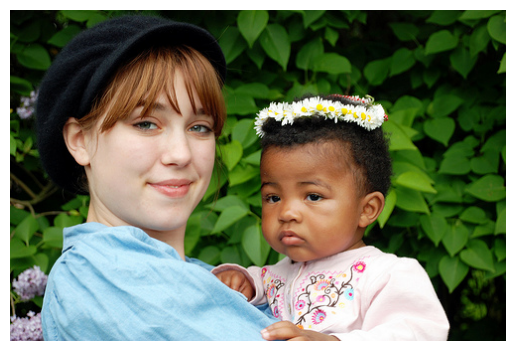

True Caption: ['A girl in black hat holding an african american baby .', 'A lady with a black hat holds a little girl with a crown of flowers .', 'A woman holding a baby after a wedding', 'A young woman holds a baby with flowers on its head .', 'The red hair woman wearing a black tartan hat holds a baby with flowers on her head .'] 

Predicted Caption: a man in a red shirt is standing on a sidewalk 

BLEU Score: 0.40837834627016956


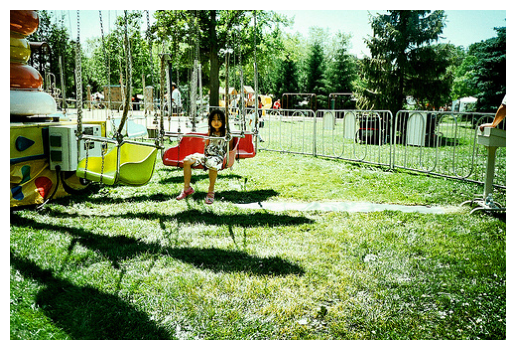

True Caption: ['A girl in a dress sitting on a red swing ride .', 'a girl sits on a swing ride .', 'A small Asian girl is sitting in a red seat on a merry go round .', 'The girl is sitting on a swing .', 'The young girl is sitting on the swing seat waiting for the carnival ride to begin .'] 

Predicted Caption: a man in a red shirt is riding a bike 

BLEU Score: 0.5109783427965771


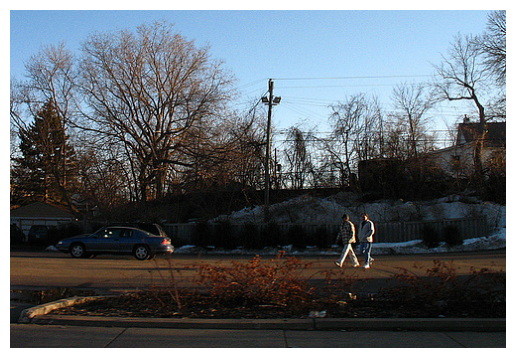

True Caption: ['Two adults walking in the street in a suburban area', 'Two distant boys walking down snowy street in urban area .', 'Two people walking across a street .', 'Two people walking on a street with barren trees .', 'Two people walking on the street with lots of bare trees around and snow on the ground .'] 

Predicted Caption: a man in a red shirt is standing on a rock 

BLEU Score: 0.42262576937354335


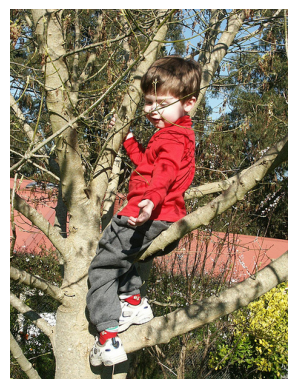

True Caption: ['A little boy in a red sweater is climbing a tree .', 'A little boy in red is climbing a tree .', 'A small child in a tree .', 'A toddler in a red sweatshirt and grey sweatpants in the branches of a tree', 'A young boy in a red shirt plays in a tree .'] 

Predicted Caption: a group of people are standing in a city street 

BLEU Score: 0.36339786837950194
Average BLEU Score on the random 6 test images: 0.4472042094102877


In [37]:
print("\n\n")
n = 6
# Calculate Average n pictures
bleu_score = evaluate_random_images(caption_model, test_data, vectorization, num_images=n)
print(f"Average BLEU Score on the random {n} test images: {bleu_score}")


## This Section is used to compares with LSTM model

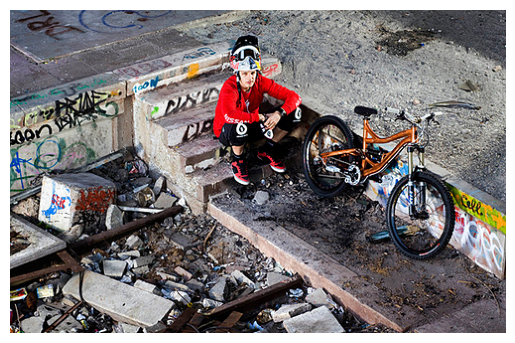

Images ID =  3613424631_3ae537624f.jpg
True Caption: ['A cyclist sits on some steps with his bike .', 'A helmeted man sits on steps with graffiti on them , and a bike nearby .', 'A man sits on the stairs next to his bike .', 'A man with his bike amid a demolished building .', 'Man with a bike sitting next to rubble .'] 

Predicted Caption: a group of people are standing in a city street 

BLEU Score: 0.2821052985077617


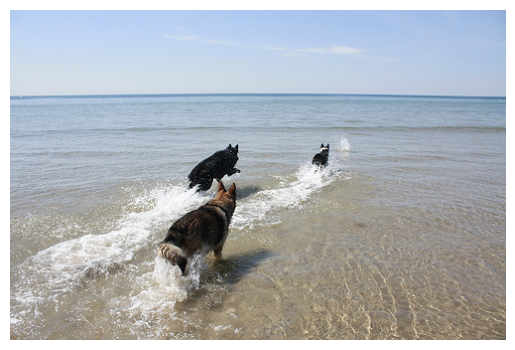

Images ID =  3630641436_8f9ac5b9b2.jpg
True Caption: ['Three dogs are running in the water on the beach .', 'Three dogs entering the ocean .', 'Three dogs rush to chase a ball thrown into the surf .', 'Three dogs walking away on the waters edge of the shore .', 'Three large dogs are playing in the water at the beach .'] 

Predicted Caption: a man is surfing on a wave 

BLEU Score: 0.2310212624356348


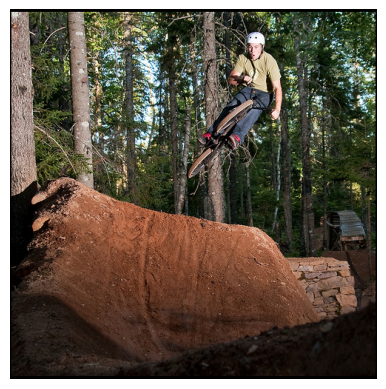

Images ID =  3640422448_a0f42e4559.jpg
True Caption: ['A bicyclist flies through the air as he encounters a tree in his path .', 'A bicyclist is jumping over a large object .', 'A man on a bike is jumping off a dirt ramp .', 'A man wearing a light brown shirt is riding a dirt bike in the woods .', 'A mountain biker is jumping his bike over a tree stump in the woods .'] 

Predicted Caption: a man in a red shirt is jumping a bike 

BLEU Score: 0.5037732702450021


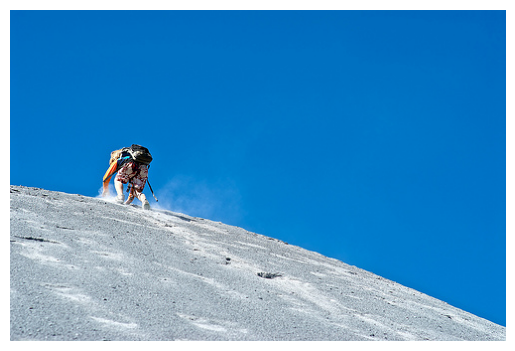

Images ID =  3745451546_fc8ec70cbd.jpg
True Caption: ['A hiker ascends a snowy hill .', 'A man reaches the top of a tall sand dune .', 'A person is hiking to the top of a hill .', 'A person walks up a white sandy hill against the blue sky .', 'The person is wearing shorts and climbing a gray sand hill under a blue sky .'] 

Predicted Caption: a person is on a snowboard in the air 

BLEU Score: 0.5150613880059216
Average BLEU Score on the some test images: 0.38299030479858004


In [38]:
def evaluate_model_on_some_images(model, test_data, vectorization):
    bleu_scores = []
    count = 0
    select_pics = [
        '3640422448_a0f42e4559.jpg',
        '3613424631_3ae537624f.jpg',
        '3630641436_8f9ac5b9b2.jpg',
        '3745451546_fc8ec70cbd.jpg',
    ]

    for img_path, true_captions in test_data.items():
        img_name = os.path.basename(img_path)  # Extracts only the file name from the full path
#         print(img_name)
        if img_name in select_pics:

            # Generate predicted caption
            predicted_caption = generate_caption(img_path)

            # Calculate BLEU score
            chencherry = SmoothingFunction()
            bleu_score = sentence_bleu(true_captions, predicted_caption, smoothing_function=chencherry.method1)
            bleu_scores.append(bleu_score)

            # Load and display the image
            img = plt.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()


            print("Images ID = ",img_name)
            # Print true caption, predicted caption, and BLEU score
            true_captions_ = [caption.replace("<start> ", "").replace(" <end>", "").strip() for caption in true_captions]
            print("True Caption:", true_captions_,"\n")
            predicted_caption_ = predicted_caption.replace("<unknown> ", "").strip()
            print("Predicted Caption:", predicted_caption_,"\n")
            print("BLEU Score:", bleu_score)
            print("=" * 50)

    # Compute average BLEU score
    if bleu_scores:
        average_bleu = sum(bleu_scores) / len(bleu_scores)
    else:
        average_bleu = 0
    return average_bleu


bleu_score = evaluate_model_on_some_images(caption_model, test_data, vectorization)
print(f"Average BLEU Score on the some test images: {bleu_score}")